In [1]:
import pandas as pd

In [2]:
dfs=pd.read_csv("ctrainb_opt.csv")

In [3]:
# Separate features and target
Xs = dfs.drop('label', axis=1)
ys = dfs['label']

In [4]:
df=pd.read_csv("ctrainb.csv")

In [5]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [6]:
dft=pd.read_csv("ctestb.csv")

In [7]:
# Separate features and target
Xt = dft.drop('label', axis=1)
yt = dft['label']

In [9]:
from pyswarms.single import GlobalBestPSO
from sklearn.model_selection import cross_val_score

In [10]:
import numpy as np

In [11]:
param_bounds = {
    'C': (0.1, 100.0),                
    'gamma': (1e-4, 1.0),             
    'degree': (2, 5) 
}

In [12]:
def run_pso_search(model_class, param_bounds, X_train, y_train, cv=5, scoring=None):
 
    param_names = list(param_bounds.keys())
    bounds = np.array([list(b) for b in param_bounds.values()]).T  
    
    # Objective function for PSO to minimize
    def objective_function(params):
        scores = []
        for particle in params:
            param_dict = {name: value for name, value in zip(param_names, particle)}
            
            for k in param_dict:
                if isinstance(param_bounds[k][0], int):
                    param_dict[k] = int(param_dict[k])
            
            model = model_class(**param_dict)
            cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
            scores.append(-cv_score.mean())  
        return np.array(scores)
    
    # Initialize PSO optimizer
    optimizer = GlobalBestPSO(
        n_particles=20,   
        dimensions=len(param_names),
        options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        bounds=bounds
    )
    
    # Run optimization
    best_cost, best_position = optimizer.optimize(objective_function, iters=30)
    
    # Retrieve best parameters
    best_params = {name: int(val) if isinstance(param_bounds[name][0], int) else val 
                   for name, val in zip(param_names, best_position)}
    
    print("Best parameters:", best_params)
    print("Best score:", -best_cost)
    
    return best_params

In [13]:
from sklearn.svm import SVC

In [14]:
best_params = run_pso_search(
    model_class=SVC,
    param_bounds=param_bounds,
    X_train=Xs,
    y_train=ys,
    cv=5,
    scoring='accuracy'
)

2025-11-12 19:45:38,842 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.979
2025-11-12 22:36:10,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9791567989526218, best pos: [83.85952956  0.99082017  4.88603816]


Best parameters: {'C': np.float64(83.85952955832735), 'gamma': np.float64(0.9908201651502104), 'degree': 4}
Best score: 0.9791567989526218


In [15]:
import joblib
joblib.dump(best_params,"best_pso_svm_alc_b.pkl")

['best_pso_svm_alc_b.pkl']

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


In [18]:
import numpy as np

In [19]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, class_names=None):
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification report 
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Macro F1
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1 Score: {macro_f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.unique(y_test),
                yticklabels=class_names if class_names else np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix PSO SVM Binary')
    plt.savefig("Confusion Matrix PSO SVM Binary", dpi=800, bbox_inches='tight')

    plt.show()
    
    return model, y_pred

In [21]:
model = SVC(**best_params, random_state=42)


Accuracy: 0.9782

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     13370
           1       0.90      0.99      0.94      2984

    accuracy                           0.98     16354
   macro avg       0.95      0.98      0.96     16354
weighted avg       0.98      0.98      0.98     16354

Macro F1 Score: 0.9649

Confusion Matrix:
[[13034   336]
 [   20  2964]]


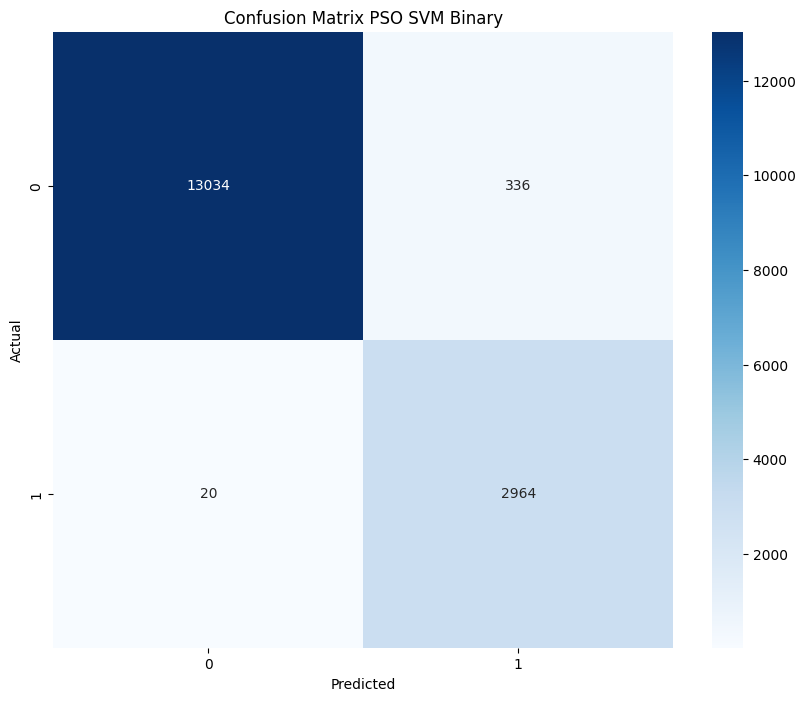

In [22]:
model, pred = train_and_evaluate(model, X, y, Xt, yt)


In [23]:
import joblib
joblib.dump(model,"pso_SVM_alc_binary.pkl")

['pso_SVM_alc_binary.pkl']